<a href="https://colab.research.google.com/github/kamijoseph/Air-Quality/blob/main/notebook/air_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# air quality predictor

## dependencies

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## dataset

In [4]:
data = pd.read_csv("/content/air.csv")
data.head(10)

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,Moderate
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,Moderate
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,Moderate
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,Good
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,Good
5,39.4,96.6,14.6,35.5,42.9,17.9,1.82,3.1,674,Hazardous
6,41.7,82.5,1.7,15.8,31.1,12.7,1.80,4.6,735,Poor
7,31.0,59.6,5.0,16.8,24.2,13.6,1.38,6.3,443,Moderate
8,29.4,93.8,10.3,22.7,45.1,11.8,2.03,5.4,486,Poor
9,33.2,80.5,11.1,24.4,32.0,15.3,1.69,4.9,535,Poor


In [5]:
data.shape

(5000, 10)

## simple exploratory dataset analysis

In [6]:
# info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Temperature                    5000 non-null   float64
 1   Humidity                       5000 non-null   float64
 2   PM2.5                          5000 non-null   float64
 3   PM10                           5000 non-null   float64
 4   NO2                            5000 non-null   float64
 5   SO2                            5000 non-null   float64
 6   CO                             5000 non-null   float64
 7   Proximity_to_Industrial_Areas  5000 non-null   float64
 8   Population_Density             5000 non-null   int64  
 9   Air Quality                    5000 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 390.8+ KB


In [7]:
# checking for missing values
data.isnull().sum()

,0
Temperature,0
Humidity,0
PM2.5,0
PM10,0
NO2,0
SO2,0
CO,0
Proximity_to_Industrial_Areas,0
Population_Density,0
Air Quality,0


In [8]:
# duplicates
data.duplicated().sum()

np.int64(0)

In [9]:
# statistical description
data.describe()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,30.029020,70.056120,20.142140,30.218360,26.412100,10.014820,1.500354,8.425400,497.423800
std,6.720661,15.863577,24.554546,27.349199,8.895356,6.750303,0.546027,3.610944,152.754084
min,13.400000,36.000000,0.000000,-0.200000,7.400000,-6.200000,0.650000,2.500000,188.000000
25%,25.100000,58.300000,4.600000,12.300000,20.100000,5.100000,1.030000,5.400000,381.000000
50%,29.000000,69.800000,12.000000,21.700000,25.300000,8.000000,1.410000,7.900000,494.000000
75%,34.000000,80.300000,26.100000,38.100000,31.900000,13.725000,1.840000,11.100000,600.000000
max,58.600000,128.100000,295.000000,315.800000,64.900000,44.900000,3.720000,25.800000,957.000000


In [10]:
# air quality classes
data["Air Quality"].value_counts()

,count
Air Quality,
Good,2000
Moderate,1500
Poor,1000
Hazardous,500


In [11]:
features = data.drop("Air Quality", axis=1)
features = features.columns.tolist()
features

['Temperature',
 'Humidity',
 'PM2.5',
 'PM10',
 'NO2',
 'SO2',
 'CO',
 'Proximity_to_Industrial_Areas',
 'Population_Density']

In [12]:
# detecting outliers using the 1qr method function
def detect_outlier(data, features, multiplier=1.5):
  summary = []
  outlier_indices = set()

  for feature in features:
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    # outlier indieces
    outliers = data[
        (data[feature] < lower_bound) | (data[feature] > upper_bound)
    ]
    outlier_indices.update(outliers)

    # outliers summary
    summary.append({
        "Feature": feature,
        "Outlier_Count": len(outliers),
        "Percentage": round(
            (len(outliers) / len(data)) * 100, 2
        )
    })

  # summary dataframe
  outlier_summary = pd.DataFrame(summary).sort_values(
      by = "Outlier_Count",
      ascending = False
  )

  return outlier_summary


In [13]:
# outliers
summary = detect_outlier(data, features)
summary

,Feature,Outlier_Count,Percentage
2,PM2.5,352,7.04
3,PM10,324,6.48
5,SO2,124,2.48
4,NO2,73,1.46
0,Temperature,72,1.44
6,CO,45,0.90
1,Humidity,19,0.38
7,Proximity_to_Industrial_Areas,16,0.32
8,Population_Density,7,0.14


## insights:
  - neither duplicates nor missing values
  - imbalances classes
  - only classes are in objects dtype (encode during preprocessing)

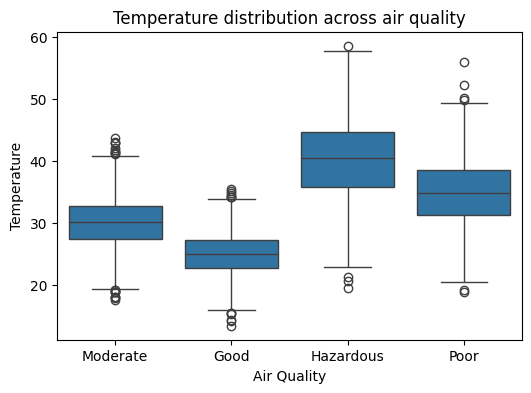

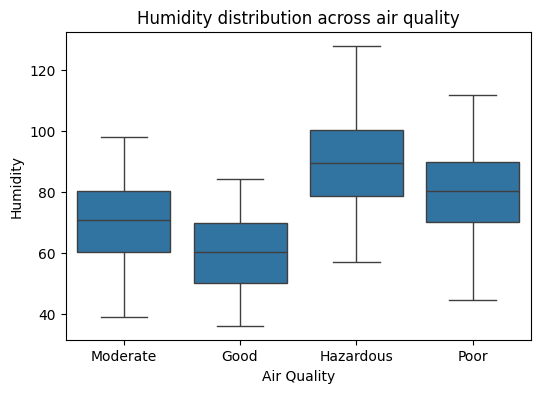

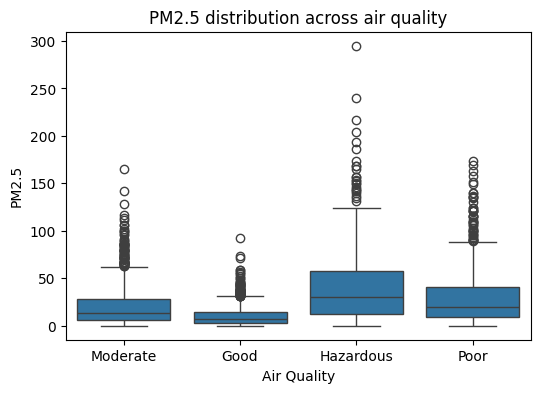

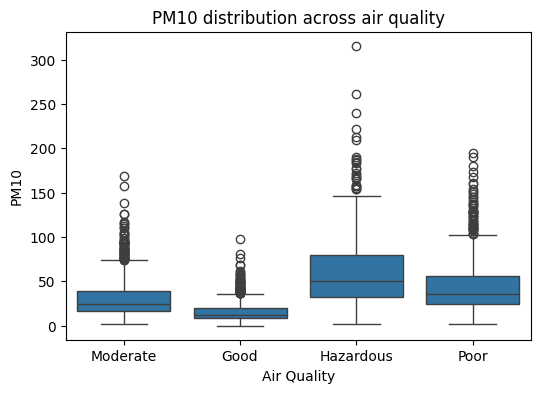

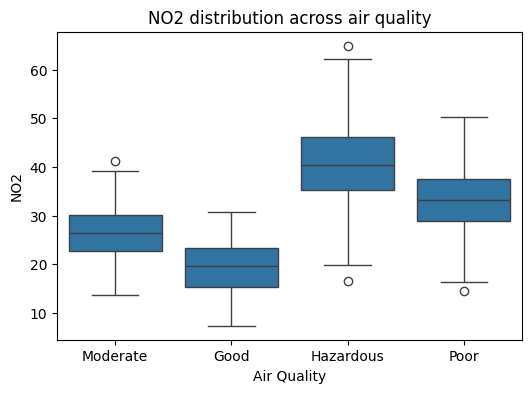

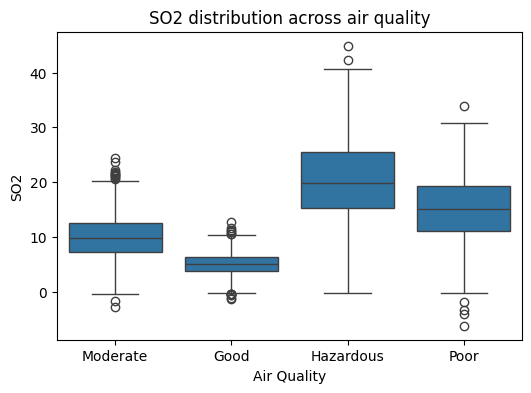

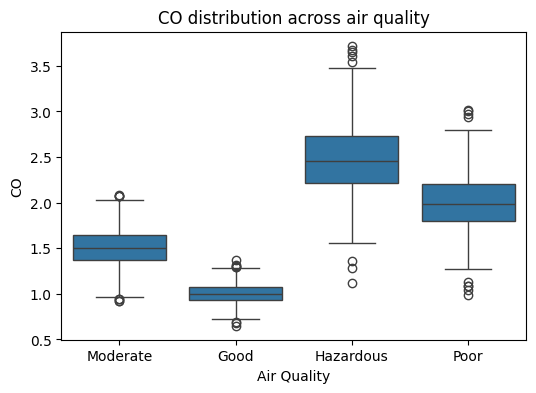

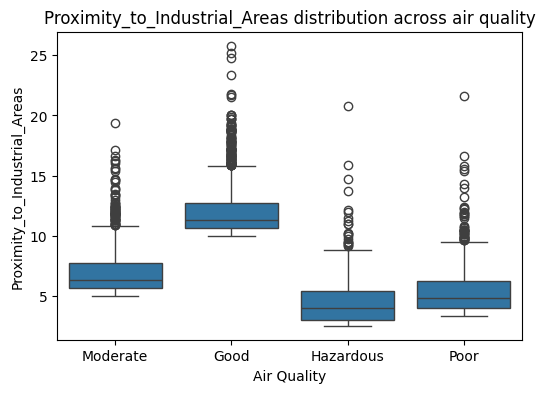

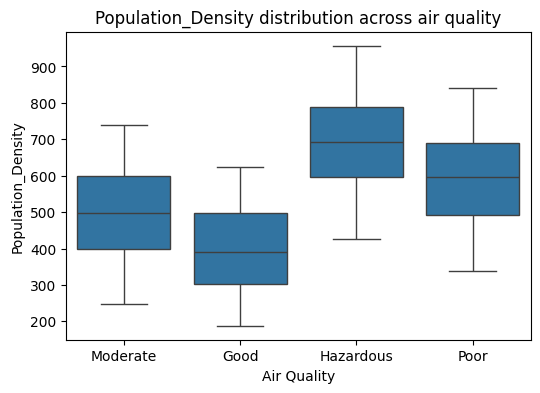

In [14]:


# boxplots of features distribution across air quality classes
for feature in features:
  plt.figure(figsize=(6, 4))
  sns.boxplot(
      x = "Air Quality",
      y = feature,
      data = data
  )
  plt.title(f"{feature} distribution across air quality")
  plt.show()

